# AI과정 miniProject
### FIFA 선수 이적료 예측 경진대회 ( Dataset from DACON )

- FIFA_train.csv / FIFA_test.csv
- Player Dataset Column Information
  - id : 선수 고유의 아이디
  - name : 이름
  - age : 나이
  - continent : 선수들의 국적이 포함되어 있는 대륙입니다
  - contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
  - position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
  - prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
  - reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
  - stat_overall : 선수의 현재 능력치 입니다.
  - stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
  - stat_skill_moves : 선수의 개인기 능력치 입니다.
  - value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다



- submission.csv
- id 값을 통해 value 값을 추출해야 한다.
  - id : 선수 고유의 아이디
  - value : 예측된 선수 이적 시장 가격을 기입
  
  

In [6]:
# module import
## pandas, numpy
import numpy as np
import pandas as pd

# Visualization Module
## matplotlib, seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# gif
from matplotlib.animation import FuncAnimation

# ignore warning
import warnings
warnings.filterwarnings(action='ignore')


In [7]:
# Data load
## 이건 나중에 맞춰야 할듯 합니다. 우선은 에러 줄이기 위해 local에서 진행

train_df = pd.read_csv('.\\data\\FIFA_train.csv')
test_df = pd.read_csv('.\\data\\FIFA_test.csv')
submission_df = pd.read_csv('.\\data\\submission.csv')
#submission_df = pd.read_csv('.\\data\\submission.csv')

train = train_df.copy()
test = test_df.copy()

In [7]:
# Data Check

train_df.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


## Data Time insight

1. 데이터 내의 나이와 현재 나이의 차를 통해 데이터 생성 시기는 "2018년"으로 간주


2. Data 의 value 값의 단위는 EUR(€, 유로), 하지만 편하게 분석, 해석 하기 위해. 대한민국의 화폐 단위인 원단위로 변경 후 작업


3. 원단위로 변경은 데이터 생성 시기인 2018년의 원화<>유로 환률의 평균값으로 계산

4. 1 EUR(€, 유로) = 1299.65 원 (\, 원화)로 가정하고 작업 진행

5. 시각화는 EUR(€, 유로)로 진행

In [5]:
# Data 이상치, NaN값 타입 확인

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


<AxesSubplot:>

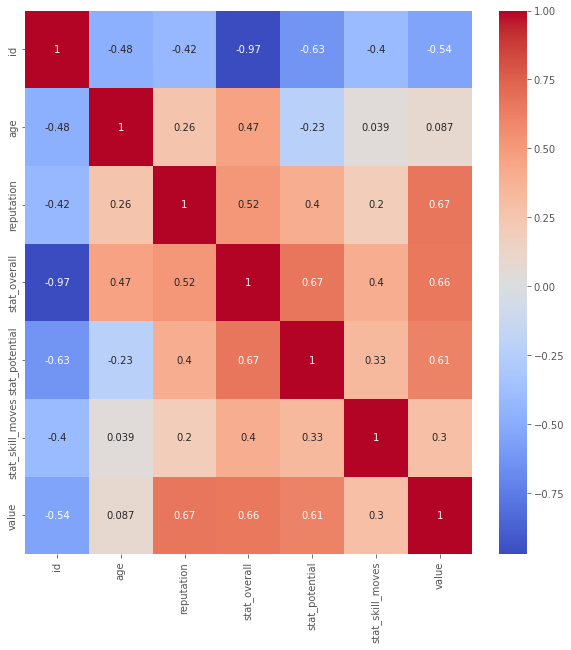

In [6]:


tmp = train_df.corr()
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
sns.heatmap(tmp, cmap='coolwarm', annot=True)

### value 에 영향을 미치는값의 분석


- reputation(0.67, 인기), stat_overall(0.66, 능력치), stat_potential(0.61, 성장가능성)

- value 값은 위 3개의 요소에 가장 많은 영향을 받는다.

- value(이적 시장 가격)와 관계가 높은 것은 'stat_overall', 'reputation', 'stat_potential'







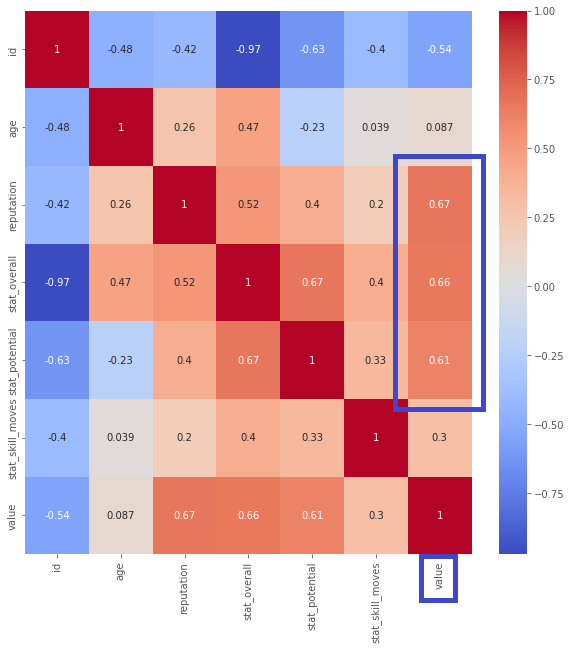



<AxesSubplot:xlabel='stat_overall', ylabel='value'>

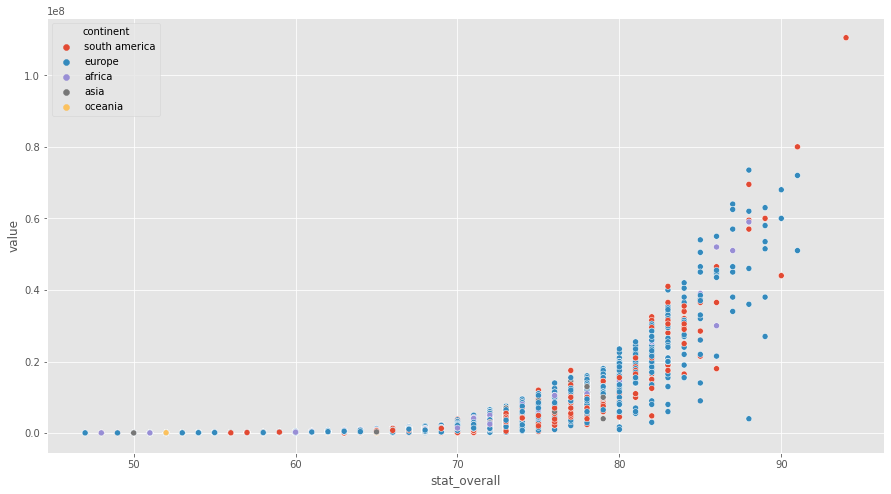

In [7]:
plt.figure(figsize=(15,8))
plt.style.use('ggplot')
sns.scatterplot(data=train_df, x='stat_overall', y ='value',hue='continent')

<Figure size 1080x576 with 0 Axes>

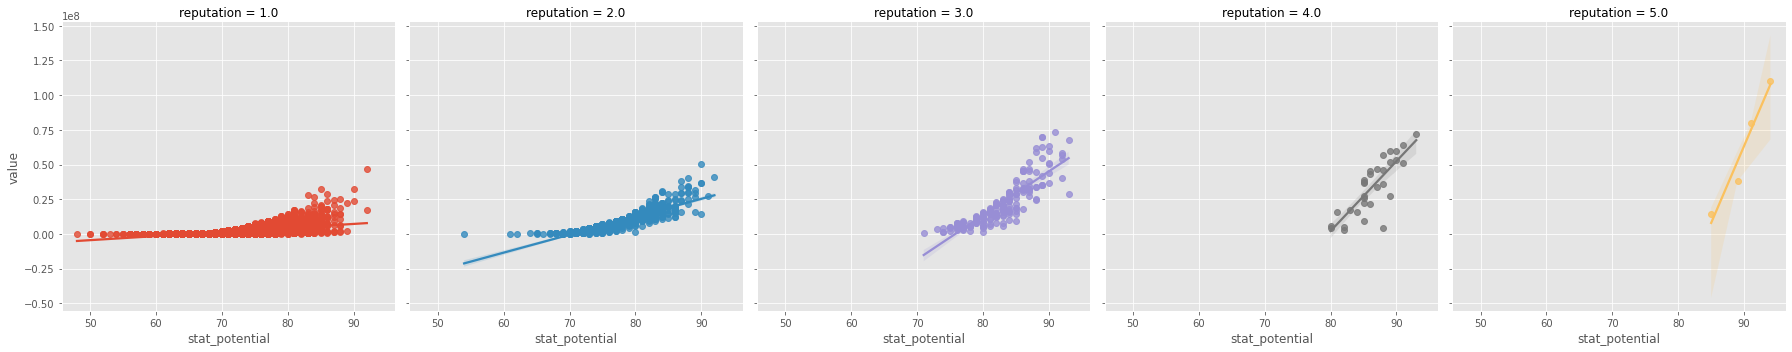

In [8]:
plt.figure(figsize=(15,8))
sns.lmplot(data=train_df, x='stat_potential', y ='value',col='reputation',hue='reputation')

# reputation이 높아질수록 value값이 가파르게 높아지고, stat_potential 또한 평균값이 높았다.

# 시각화

1. 축구선수에게 가장 중요한 value값을 기준으로 가장 관련있는 요소를 통해 시각화 진행
    - reputation(0.67, 인기), stat_overall(0.66, 능력치), stat_potential(0.61, 성장가능성)



2. value 값 외 대륙을 나타내는 continent(대륙)값 별로 value을 분류
    - continent(대륙)을 기준으로 선택한 이유 : 데이터 속성의 갯수가 분류 하기 적절함



3. 숫자형 자료와, 문자형 자료를 나눠서 진행
    - 숫자형 자료 \
    ['age', 'stat_overall', 'stat_potential']
    
    - 문자형 자료\
    ['continent', 'contract_until' ,'position', 'prefer_foot', 'reputation', 'stat_skill_moves'] 


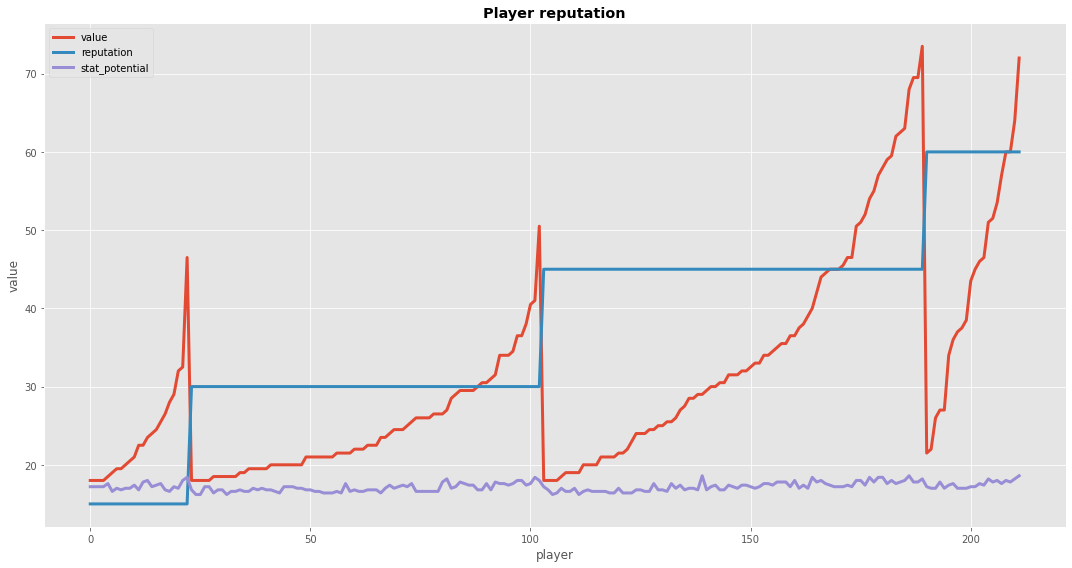

In [10]:
fig=plt.figure(figsize=(15,8))


import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image
#imageio.plugins.ffmpeg.download()

data1 =  pd.to_numeric(tmp_df['value'], downcast='float')
data2 =  pd.to_numeric(tmp_df['reputation'], downcast='float')
data3 =  pd.to_numeric(tmp_df['stat_potential'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1] 
    #y4 = data4[:i+1] 
    
    plt.cla()
    plt.plot(x, y1, label='value', lw=3)
    plt.plot(x, y2, label='reputation', lw=3)
    plt.plot(x, y3, label='stat_potential', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)
    
    plt.title('Player reputation', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
ani = FuncAnimation(plt.gcf(), animate, frames=212, interval=1)
ani.save('./animation_single.gif', fps=30)

Img(url='animation_single.gif')
#print('GIF_make_finish')


In [69]:
train_df['reputation'].value_counts()

1.0    8014
2.0     706
3.0     177
4.0      31
5.0       4
Name: reputation, dtype: int64

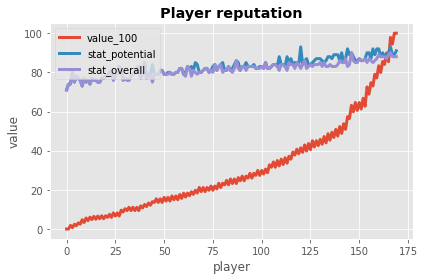

In [72]:
def makegif(re):

    from sklearn.preprocessing import MinMaxScaler
    import os
    from PIL import Image
    from IPython.display import Image as Img
    from IPython.display import display
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    import matplotlib as mpl
    from matplotlib import font_manager, rc
    import sys
    import imageio
    from PIL import Image

    tmp_data = train_df[['value','reputation','stat_potential','stat_overall']]
    tmp_data = tmp_data[tmp_data['reputation']==re]
    tmp_data = tmp_data.sample(170)
    tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

    scaler = MinMaxScaler()
    numeric_data = tmp_data['value'].values
    tmp = numeric_data.reshape(-1,2)
    tmp_fit = scaler.fit(tmp)
    tmp_trans = scaler.transform(tmp)
    tmp_re=tmp_trans.reshape(-1,)
    tmp_data['value_100'] = tmp_re*100


    data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
    data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
    data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
    #data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


    def animate(i):
        x = np.linspace(0,i,i+1)
        y1 = data1[:i+1]
        y2 = data2[:i+1]
        y3 = data3[:i+1]
        #y4 = data4[:i+1] 

        plt.cla()
        plt.plot(x, y1, label='value_100', lw=3)
        plt.plot(x, y2, label='stat_potential', lw=3)
        plt.plot(x, y3, label='stat_overall', lw=3)
        #plt.plot(x, y4, label='stat_overall', lw=3)

        plt.title('Player reputation', fontweight='bold')
        plt.ylabel('value')
        plt.xlabel('player')
        plt.legend(loc='upper left')
        plt.tight_layout()

    ani = FuncAnimation(plt.gcf(), animate, frames=170, interval=1)
    ani.save('./animation_single{}.gif'.format(re), fps=17)


    Img(url='animation_single{}.gif'.format(re))

        


makegif(3)

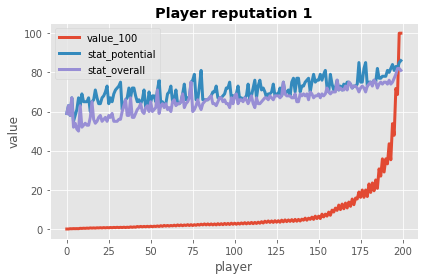

In [74]:
# reputation = 1 인 선수 랜던 200명의 값

from sklearn.preprocessing import MinMaxScaler
import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image

tmp_data = train_df[['value','reputation','stat_potential','stat_overall']]
tmp_data = tmp_data[tmp_data['reputation']==1]
tmp_data = tmp_data.sample(200)
tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

scaler = MinMaxScaler()
numeric_data = tmp_data['value'].values
tmp = numeric_data.reshape(-1,2)
tmp_fit = scaler.fit(tmp)
tmp_trans = scaler.transform(tmp)
tmp_re=tmp_trans.reshape(-1,)
tmp_data['value_100'] = tmp_re*100


data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 

    plt.cla()
    plt.plot(x, y1, label='value_100', lw=3)
    plt.plot(x, y2, label='stat_potential', lw=3)
    plt.plot(x, y3, label='stat_overall', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)

    plt.title('Player reputation 1', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=200, interval=1)
ani.save('./reputation_1.gif', fps=20)


Img(url='reputation_1.gif')

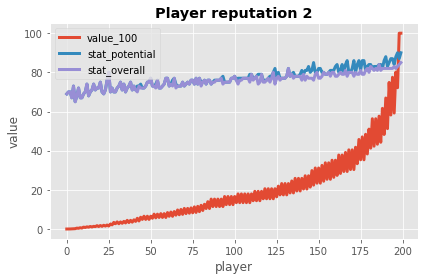

In [75]:
# reputation = 2 인 선수 랜던 200명의 값

from sklearn.preprocessing import MinMaxScaler
import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image

tmp_data = train_df[['value','reputation','stat_potential','stat_overall']]
tmp_data = tmp_data[tmp_data['reputation']==2]
tmp_data = tmp_data.sample(200)
tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

scaler = MinMaxScaler()
numeric_data = tmp_data['value'].values
tmp = numeric_data.reshape(-1,2)
tmp_fit = scaler.fit(tmp)
tmp_trans = scaler.transform(tmp)
tmp_re=tmp_trans.reshape(-1,)
tmp_data['value_100'] = tmp_re*100


data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 

    plt.cla()
    plt.plot(x, y1, label='value_100', lw=3)
    plt.plot(x, y2, label='stat_potential', lw=3)
    plt.plot(x, y3, label='stat_overall', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)

    plt.title('Player reputation 2', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=200, interval=1)
ani.save('./reputation_2.gif', fps=20)


Img(url='reputation_2.gif')

In [77]:
train_df['reputation'].value_counts()

1.0    8014
2.0     706
3.0     177
4.0      31
5.0       4
Name: reputation, dtype: int64

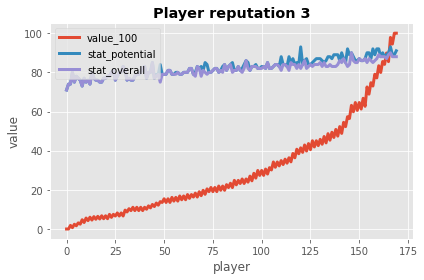

In [80]:
# reputation = 3 인 선수 랜던 200명의 값
# 1.0    8014
# 2.0     706
# 3.0     177
# 4.0      31
# 5.0       4
# reputation = 3  인 선수가 177명 이기 때문에 170명만 뽑을 예정
# 주의 할점, animation의 frame 값과 fps값도 바꿔줘야함,
# MinMaxSacler를 위해 reshape를 해야 하기 때문에 샘플값을 짝수로 정해줘야함

from sklearn.preprocessing import MinMaxScaler
import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image

tmp_data = train_df[['value','reputation','stat_potential','stat_overall']]
tmp_data = tmp_data[tmp_data['reputation']==3]
tmp_data = tmp_data.sample(170)
tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

scaler = MinMaxScaler()
numeric_data = tmp_data['value'].values
tmp = numeric_data.reshape(-1,2)
tmp_fit = scaler.fit(tmp)
tmp_trans = scaler.transform(tmp)
tmp_re=tmp_trans.reshape(-1,)
tmp_data['value_100'] = tmp_re*100


data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 

    plt.cla()
    plt.plot(x, y1, label='value_100', lw=3)
    plt.plot(x, y2, label='stat_potential', lw=3)
    plt.plot(x, y3, label='stat_overall', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)

    plt.title('Player reputation 3', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=170, interval=1)
ani.save('./reputation_3.gif', fps=17)


Img(url='reputation_3.gif')

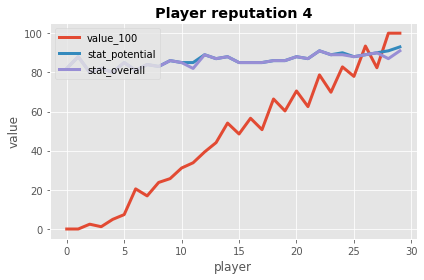

In [81]:
# reputation = 4 인 선수 랜던 200명의 값
# 1.0    8014
# 2.0     706
# 3.0     177
# 4.0      31
# 5.0       4
# reputation=3 과 같은 이유로 30명만으로 표를 그릴 예정

from sklearn.preprocessing import MinMaxScaler
import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image

tmp_data = train_df[['value','reputation','stat_potential','stat_overall']]
tmp_data = tmp_data[tmp_data['reputation']==4]
tmp_data = tmp_data.sample(30)
tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

scaler = MinMaxScaler()
numeric_data = tmp_data['value'].values
tmp = numeric_data.reshape(-1,2)
tmp_fit = scaler.fit(tmp)
tmp_trans = scaler.transform(tmp)
tmp_re=tmp_trans.reshape(-1,)
tmp_data['value_100'] = tmp_re*100


data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 

    plt.cla()
    plt.plot(x, y1, label='value_100', lw=3)
    plt.plot(x, y2, label='stat_potential', lw=3)
    plt.plot(x, y3, label='stat_overall', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)

    plt.title('Player reputation 4', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=30 , interval=1)
ani.save('./reputation_4.gif', fps=3)


Img(url='reputation_4.gif')

## value, stat_potential의 관계

- 같은 reputation 등급에서 value 와 stat_potential의 관계를 시각화

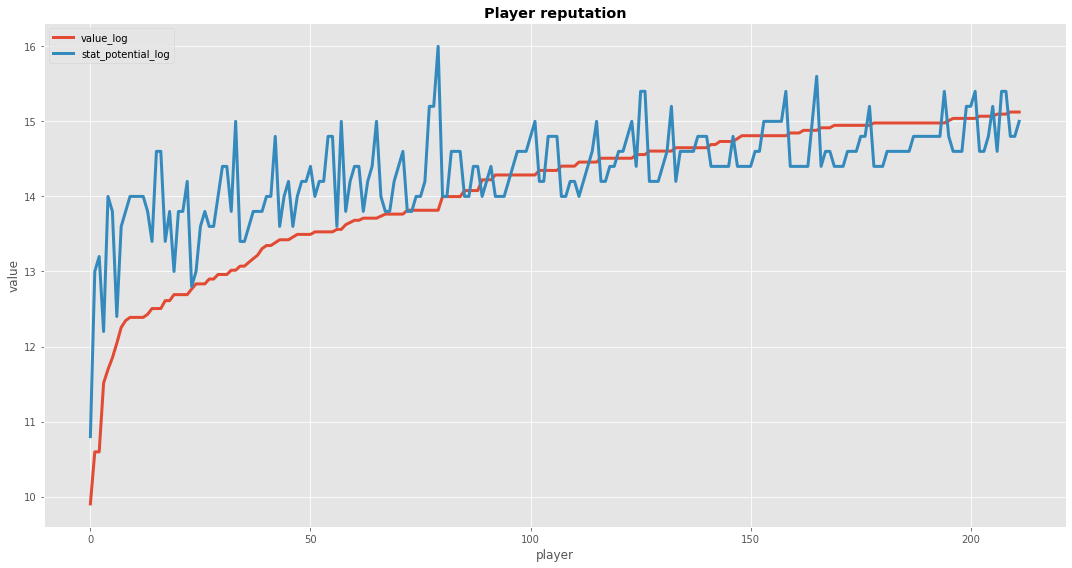

In [596]:
tmp_data_2 = train_df[['value','reputation','stat_potential']]
tmp_df = tmp_data_2.sort_values(by = ['value','reputation'], ascending=True)
tmp_df = tmp_df[(tmp_df['reputation']==1)]
tmp_df = tmp_df.sort_values(by = ['value','stat_potential'], ascending=True)
tmp_df['value_log'] = np.log(tmp_df['value'])
tmp_df['stat_potential_log'] = tmp_df['stat_potential']/5
tmp_df

fig=plt.figure(figsize=(15,8))


import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image
#imageio.plugins.ffmpeg.download()

data1 =  pd.to_numeric(tmp_df['value_log'], downcast='float')
#data2 =  pd.to_numeric(tmp_df['reputation'], downcast='float')
data3 =  pd.to_numeric(tmp_df['stat_potential_log'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    #y2 = data2[:i+1] * 9000000
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 
    
    plt.cla()
    plt.plot(x, y1, label='value_log', lw=3)
    #plt.plot(x, y2, label='reputation', lw=3)
    plt.plot(x, y3, label='stat_potential_log', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)
    
    plt.title('Player reputation', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
ani = FuncAnimation(plt.gcf(), animate, frames=212, interval=1)
ani.save('./animation_single2.gif', fps=30)

Img(url='animation_single2.gif')
#print('GIF_make_finish')

In [ ]:
# reputation 2  200명의 데이터

tmp_data_2 = train_df[['value','reputation','stat_potential']]
tmp_df = tmp_data_2.sort_values(by = ['value','reputation'], ascending=True)
tmp_df = tmp_df[(tmp_df['reputation']==2)]
tmp_df = tmp_df.sort_values(by = ['value','stat_potential'], ascending=True)
tmp_df['value_log'] = np.log(tmp_df['value'])
tmp_df['stat_potential_log'] = tmp_df['stat_potential']/5
tmp_df

fig=plt.figure(figsize=(15,8))


import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image
#imageio.plugins.ffmpeg.download()

data1 =  pd.to_numeric(tmp_df['value_log'], downcast='float')
#data2 =  pd.to_numeric(tmp_df['reputation'], downcast='float')
data3 =  pd.to_numeric(tmp_df['stat_potential_log'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    #y2 = data2[:i+1] * 9000000
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 
    
    plt.cla()
    plt.plot(x, y1, label='value_log', lw=3)
    #plt.plot(x, y2, label='reputation', lw=3)
    plt.plot(x, y3, label='stat_potential_log', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)
    
    plt.title('Player reputation', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
ani = FuncAnimation(plt.gcf(), animate, frames=212, interval=1)
ani.save('./animation_single2.gif', fps=30)

Img(url='animation_single2.gif')
#print('GIF_make_finish')

## 인사이트 시각화

- 유망주 구하기!
  - 육체적 성장가능성이 남아있는 만 17~23세 이하의 선수들을 꼽으며, 이중 육체적인 능력이 뛰어나며 스킬 획득능력과 멘탈 발전의 여지가 큰 선수들을 칭한다. 사실 어린 선수들은 신체발달을 스킬보다 중요시 하고, 멘탈에 있어서도 후천적인 가능성을 보기 때문에 유망주라고 불릴 선수들 상당수는 그나이대 같은 선수보다 덜 다듬어지고 스킬 발전이 더딜지라도 신체 능력이 뛰어나면 이를 위주로 평가하는 경우가 더 많다.

In [141]:
train_df['value'].describe().astype('int')

count         8932
mean       2778673
std        5840981
min          10000
25%         375000
50%         825000
75%        2600000
max      110500000
Name: value, dtype: int32

In [145]:
# age_df 유망주 데이터 프레임
age_df = train_df[['age','name','continent','stat_potential','value']]
age_tmp_df = age_df[(age_df['age']<=23) & (age_df['stat_potential']>=80)&(age_df['value']<=825000) ]
age_tmp_df=age_tmp_df.sort_values(by = ['age','value'], ascending=True)
age_tmp_df

,age,name,continent,stat_potential,value
7958,16,Y. Begraoui,europe,81,350000.0
7015,16,Y. Verschaeren,europe,83,650000.0
6537,16,Pelayo Morilla,europe,81,725000.0
8371,17,I. Sauter,europe,80,180000.0
8298,17,Y. Lenze,europe,82,190000.0
8238,17,Y. Toure,europe,80,230000.0
8077,17,J. von Moos,europe,84,280000.0
7937,17,S. Çetin,europe,80,300000.0
7952,17,G. Azzinnari,europe,83,350000.0
7536,17,B. Diakité,europe,80,375000.0


평균 유망주의 나이 :  17
평균 유망주의 나이 :  548545 유로


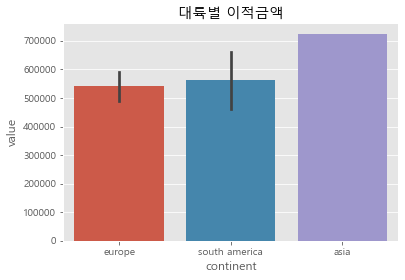

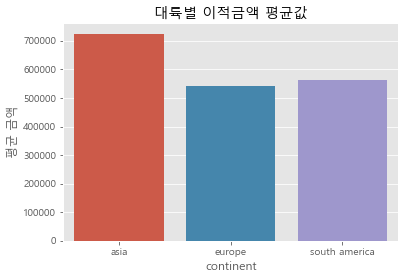

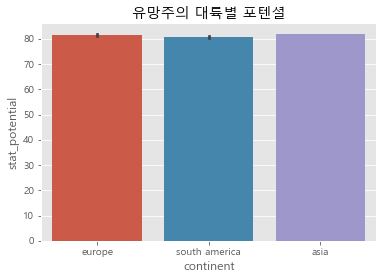

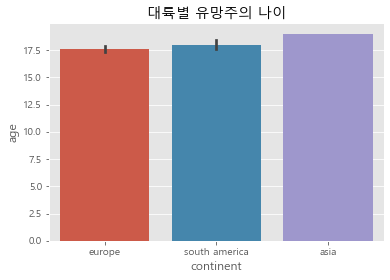

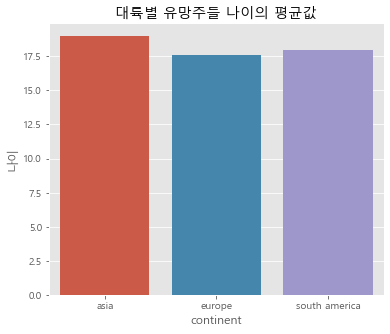

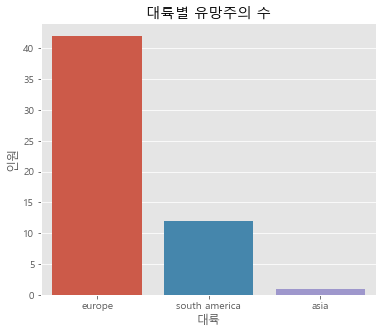

In [193]:
# 유망주 선정 기준
## stat_potential 이 80이하
## value 값이 전체 평균 이하
## age가 23세 이하
## 평균 유망주의 나이는 17세

### 그래프 분석 결과 europe으로 스카우트를 파견하는게 제일 좋아보인다.
### 우선 유망주들의 나이가 제일 적으며, 
tmp_age = age_tmp_df['age'].mean().astype('int')
tmp_value = age_tmp_df['value'].mean().astype('int')

print('평균 유망주의 나이 : ',tmp_age)
print('평균 유망주의 나이 : ',tmp_value,'유로')


plt.title('대륙별 이적금액')
plt.ylabel('금액')
sns.barplot(data = age_tmp_df, x='continent', y='value')
plt.show()

tmp = age_tmp_df.groupby('continent')['value'].mean().astype('int')
plt.title('대륙별 이적금액 평균값')
plt.xlabel('대륙')
plt.ylabel('평균 금액')
sns.barplot(x=tmp.index, y =tmp.values)
plt.show()



plt.title('유망주의 대륙별 포텐셜')
sns.barplot(data = age_tmp_df, x='continent', y='stat_potential')
plt.show()


plt.title('대륙별 유망주의 나이')
sns.barplot(data = age_tmp_df, x='continent', y='age')
plt.show()


tmp = age_tmp_df.groupby('continent')['age'].mean()
f, axes = plt.subplots(figsize=(6,5))
plt.title('대륙별 유망주들 나이의 평균값')
plt.xlabel('대륙')
plt.ylabel('나이')
sns.barplot(x=tmp.index, y =tmp.values)
plt.show()

tmp = age_tmp_df['continent'].value_counts()
f, axes = plt.subplots(figsize=(6,5))
plt.title('대륙별 유망주의 수')
plt.xlabel('대륙')
plt.ylabel('인원')
sns.barplot(x=tmp.index, y =tmp.values)
plt.show()

##  시각화2

- 데이터를 나눠서 진행

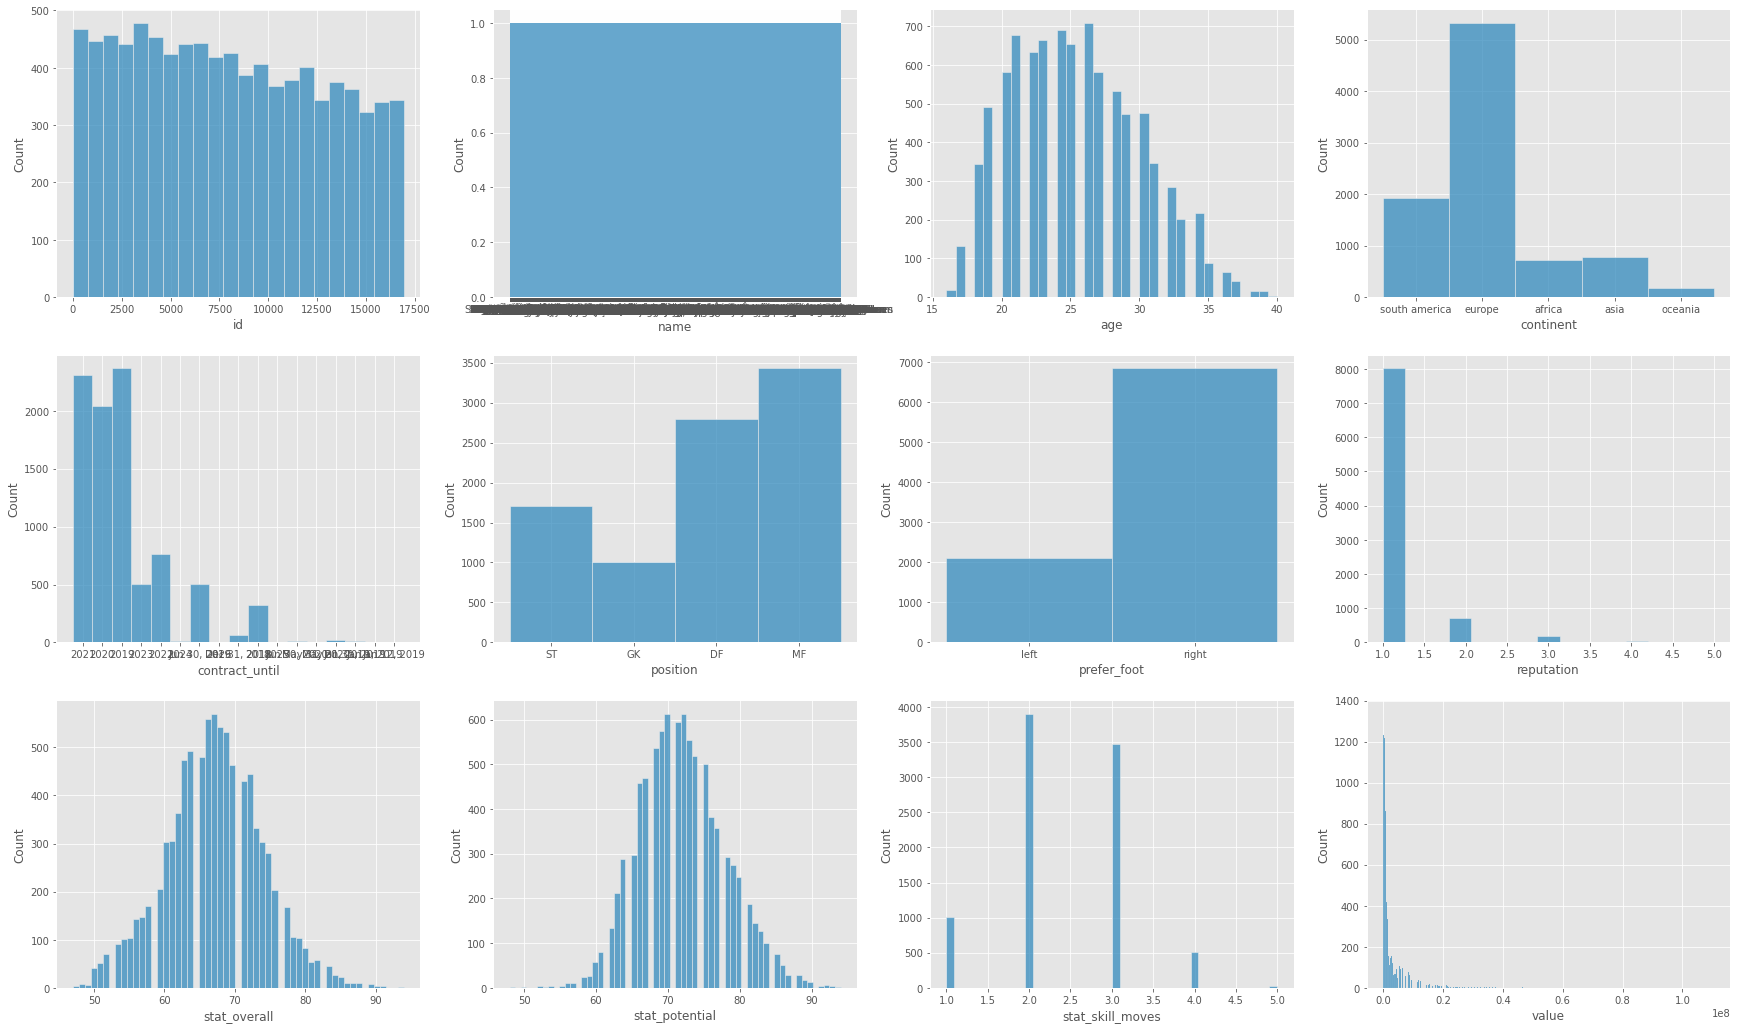

In [155]:
f, axes = plt.subplots(3,4, figsize=(30,18))
axes = axes.flatten()
for col, ax in zip(train_df.columns, axes):
  sns.histplot(data = train_df, x=col, ax=ax)
plt.show()

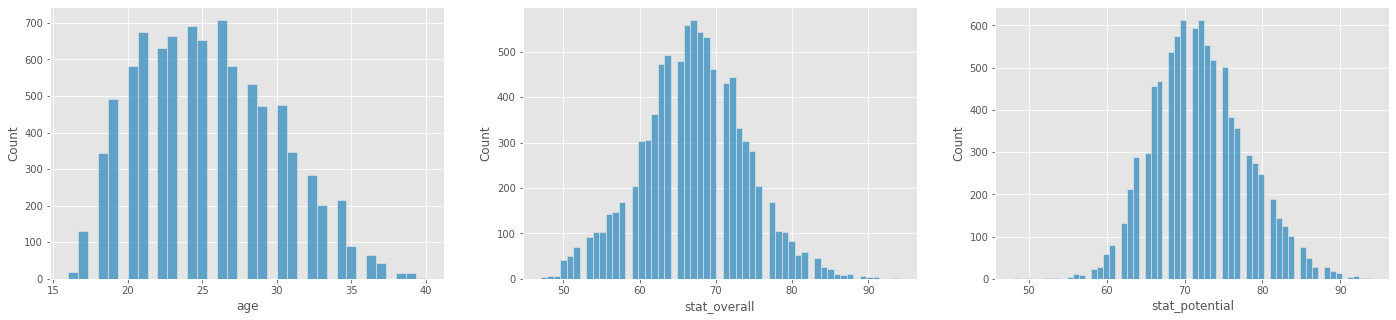

In [156]:
nums = ['age', 'stat_overall', 'stat_potential']

f, axes = plt.subplots(1,len(nums), figsize=(24,5))
axes = axes.flatten()                         
for col, ax in zip(nums, axes):
  sns.histplot(data = train_df, x=col, ax=ax)
plt.show()

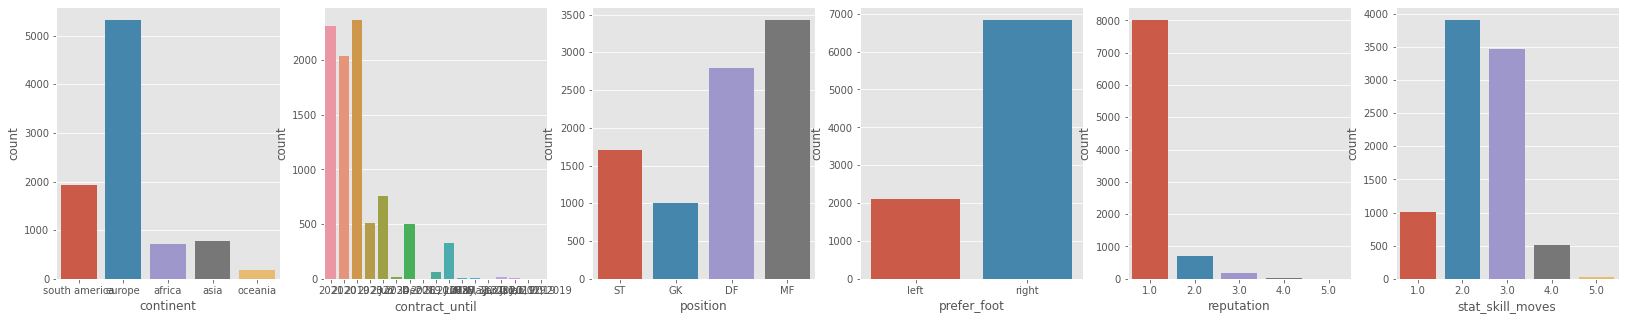

In [157]:
noms = ['continent', 'contract_until' ,'position', 'prefer_foot', 'reputation', 'stat_skill_moves'] # 이산형 (nominal)
f, axes = plt.subplots(1,len(noms), figsize=(28,5))
axes = axes.flatten()                         
for col, ax in zip(noms, axes):
  sns.countplot(data = train_df, x=col, ax=ax) 
plt.show()

###  포지션별 몸값
- 포지션 별로 value값을 봤을때, 차이가 유의미 하게 보인다.
  - ST, MF, DF, GK 순으로 높다.

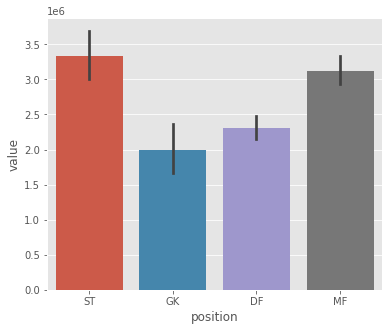

In [101]:
f, axes = plt.subplots(figsize=(6,5))
y = 'value'
sns.barplot(data = train_df, x='position', y='value') # 포지션과 몸값 사이의 관계
plt.show()

### 주로 사용하는 발에 따른 value

- 사용하는 발에 따라 value가 차이나는지 확인
  - prefer_foot에 따른 value는 크게 차이 나지 않는것을 확인

In [628]:
tmp = train_df['prefer_foot'].value_counts()
tmp

1    6837
0    2095
Name: prefer_foot, dtype: int64

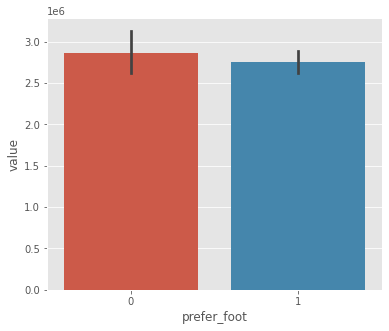

In [626]:
f, axes = plt.subplots(figsize=(6,5))       

sns.barplot(data = train_df, x='prefer_foot', y=y) # 주로쓰는 발과 몸값 사이의 관계

plt.show()



### 대륙별로 분류 후 시각화

- 대륙 별로 분류한 이유, 적당한  unique  값을 가지고 있기 때문에

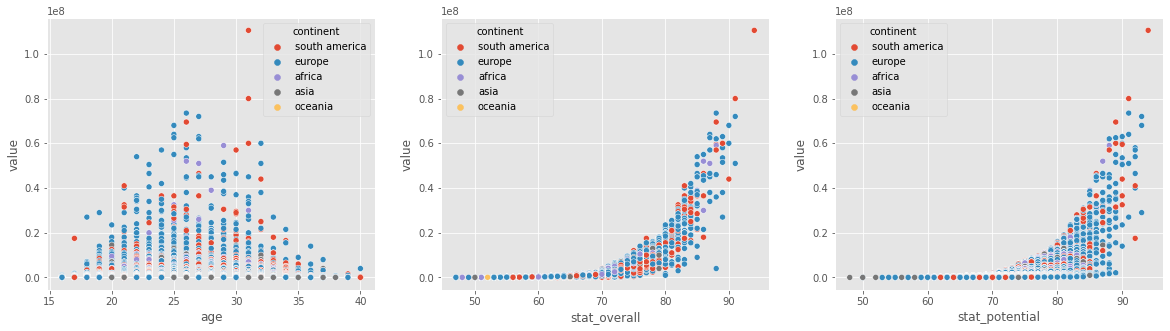

In [193]:
f, axes = plt.subplots(1,len(nums), figsize=(20,5))
axes = axes.flatten()                         
for col, ax in zip(nums, axes):
  sns.scatterplot(data = train_df, x=col, y=y, ax=ax, hue = 'continent') # 대륙별로 색을 지정
plt.show()

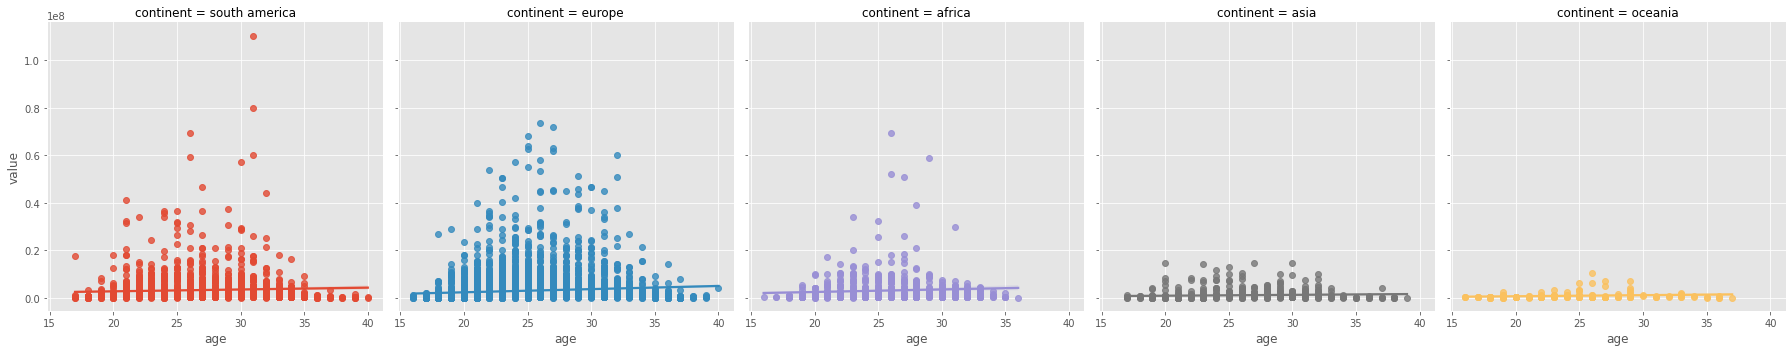

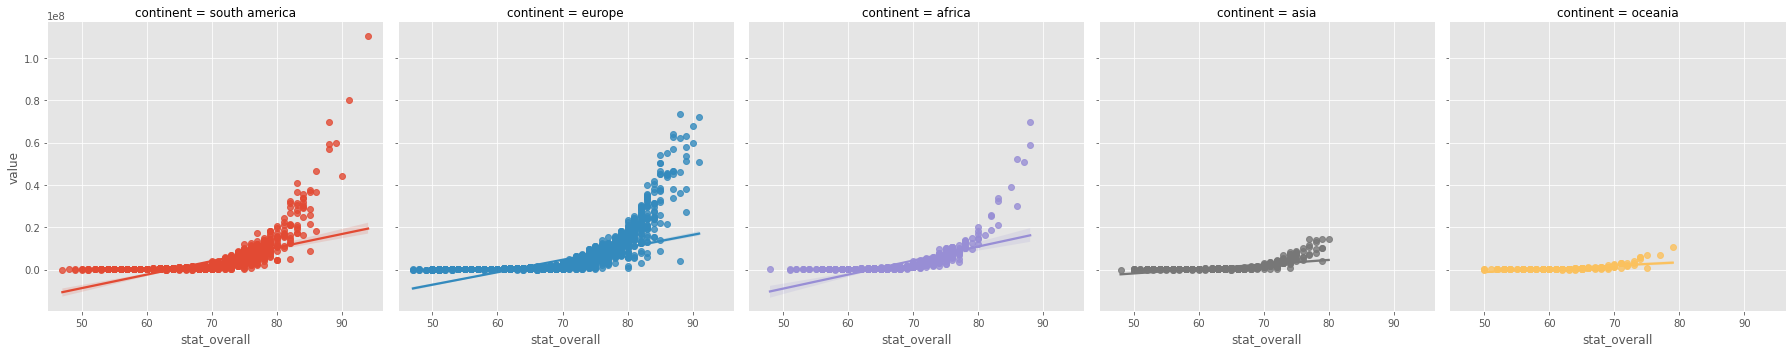

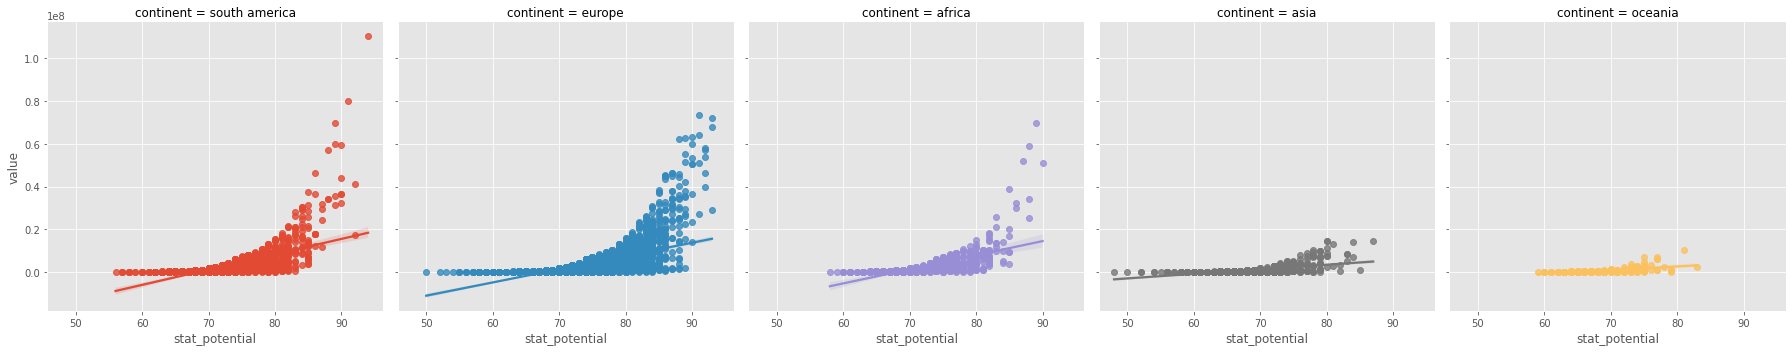

In [195]:
for col, ax in zip(nums, axes):
  sns.lmplot(data = train_df, x=col, y=y, hue='continent', col='continent') # 대륙별로 위 그래프를 분리
  plt.show()

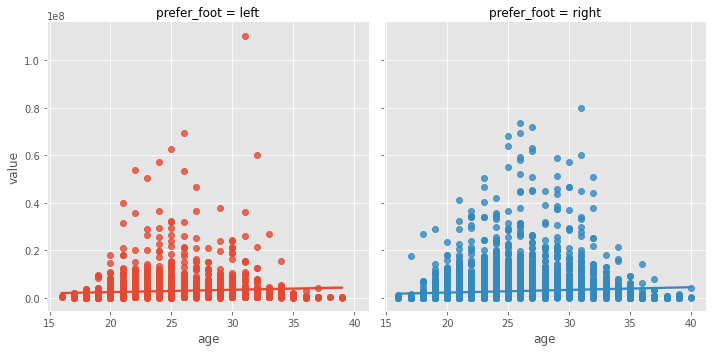

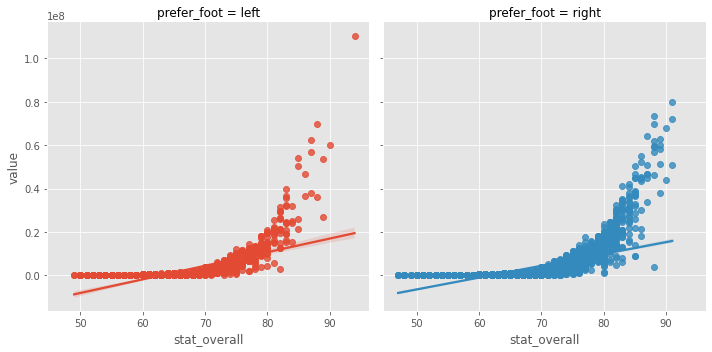

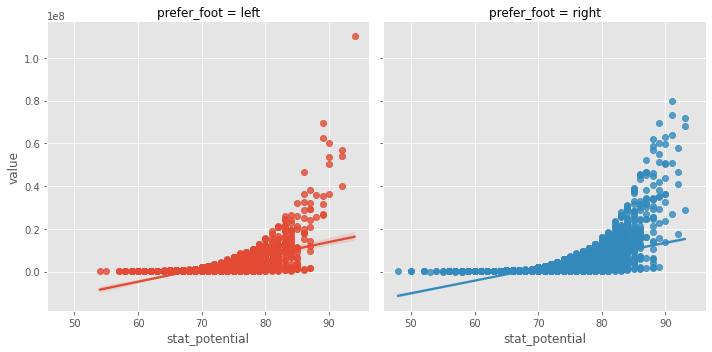

In [196]:
for col, ax in zip(nums, axes):
  sns.lmplot(data = train_df, x=col, y=y, hue='prefer_foot', col='prefer_foot') # 선호하는 발로 그래프를 분리
  plt.show()

In [618]:
tmp_data = train_df.copy()
tmp_data['age_group'] = [0]*len(tmp_data)
tmp_data.loc[(train_df['age']>=27)& (train_df['age']<=32), 'age_group'] = '27 ~ 32'
tmp_data.loc[train_df['age']< 27, 'age_group'] = '27down'
tmp_data.loc[train_df["age"] > 32, "age_group"] = "32up"

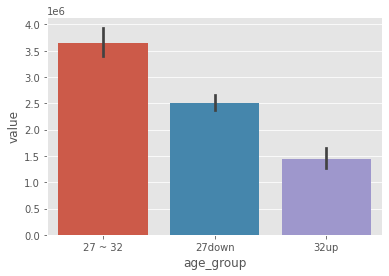

In [619]:
g = sns.barplot(x = "age_group", y = "value", data = tmp_data)
tmp_data["age_group"] = tmp_data["age_group"].astype("category")

## heatmap 지도 시각화

In [1]:
import folium
from folium import plugins

In [2]:
map = folium.Map(zoom_start= 30)
map

In [3]:
map_df = train_df[['continent']]


tmp  = map_df['continent'].value_counts()

tmp_df = pd.DataFrame(tmp)

tmp_df

NameError: name 'train_df' is not defined

In [8]:
map_df = train_df[['continent']]
tmp  = map_df['continent'].value_counts()
tmp_df = pd.DataFrame(tmp)

def converting(continent):
    if continent == 'south america':
        return -12.785707
    elif continent == 'europe':
        return 47.710319
    elif continent == 'africa':
        return 9.907480
    elif continent == 'oceania':
        return -27.270950
    else:
        return 37.5666805

def convert2(continent):
    if continent == 'south america':
        return -57.647070
    elif continent == 'europe':
        return 6.986008
    elif continent == 'africa':
        return 20.315757
    elif continent == 'oceania':
        return 136.331382
    else:
        return 126.9784147

#map_df.insert(1, ['latitude'], map_df.continent.map(lambda x: converting(x)))
#map_df.insert(2, ['longitude'], map_df.continent.map(lambda x: convert2(x)))

tmp_df['latitude'] = tmp_df['continent'].index.map(lambda x : converting(x))
tmp_df['longitude'] = tmp_df['continent'].index.map(lambda x : convert2(x))

map_df=tmp_df.copy()


map.add_child(plugins.HeatMap(zip(map_df['latitude'],map_df['longitude'],map_df['continent']), radius=20))

## 데이터 학습

In [206]:
features = ['reputation', 'stat_overall','stat_potential']
X_train = train[features]
y_train = train['value']
X_test = test[features]


In [209]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(bootstrap=True, n_estimators=200, max_depth=5, random_state=0)
model.fit(X_train, y_train)
RandomForestRegressor(max_depth=5, n_estimators=200, random_state=0)


RandomForestRegressor(max_depth=5, n_estimators=200, random_state=0)

In [233]:
y_pred = model.predict(X_test)

submission_df['value'] = y_pred.astype('int')

submission_df.to_csv('model.csv', index=False)

In [588]:
sub_df = pd.read_csv('model.csv')
sub_df

,id,value
0,1,94127748
1,2,71501479
2,4,61274391
3,5,61506981
4,6,61506981
...,...,...
3823,16924,169331
3824,16929,169331
3825,16932,169331
3826,16937,169331


In [195]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import time

In [196]:
# aseline code

# 불필요한 컬럼 제거
train_df.drop(['id', 'name'], axis = 1, inplace = True)
test_df.drop(['id', 'name'], axis = 1, inplace = True)

#contract_until 변수 int 형으로 변환
# 계약 연도만 추출
def func(string:object) -> int:
    """계약 연도만 추출하여 int로 반환"""
    string = string[-4:]
    return int(string)

train_df['contract_until'] = train_df['contract_until'].apply(func)
test_df['contract_until'] = test_df['contract_until'].apply(func)

# 문자형 변수 label 인코딩 진행
train_df['continent'] = train_df['continent'].astype('category').cat.codes
test_df['continent'] = test_df['continent'].astype('category').cat.codes

train_df['position'] = train_df['position'].astype('category').cat.codes
test_df['position'] = test_df['position'].astype('category').cat.codes

train_df['prefer_foot'] = train_df['prefer_foot'].astype('category').cat.codes
test_df['prefer_foot'] = test_df['prefer_foot'].astype('category').cat.codes

# string형 변수 변환 완료
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   continent         8932 non-null   int8   
 2   contract_until    8932 non-null   int64  
 3   position          8932 non-null   int8   
 4   prefer_foot       8932 non-null   int8   
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int64(4), int8(3)
memory usage: 514.8 KB


In [197]:
y_target = train_df['value']
X_data  = train_df.drop(['value'], axis = 1, inplace = False)

start_time = time.time()
rf = RandomForestRegressor(random_state=0, n_estimators=1000)


neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 실행시간 {0:.0f}초'.format(time.time() - start_time))

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 실행시간 39초
 5 교차 검증의 개별 Negative MSE scores:  [-1.23080444e+14 -7.07191018e+11 -2.13689716e+10 -1.36563461e+10
 -3.88981781e+10]
 5 교차 검증의 개별 RMSE scores :  [11094162.6    840946.5    146181.3    116860.37   197226.21]
 5 교차 검증의 평균 RMSE : 2479075.397 


In [201]:
rf.predict(y_target)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [599]:
def get_model_cv_prediction(model, X_data, y_target):
    start_time = time.time()
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 실행시간 {0:.0f}초'.format(time.time() - start_time))
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} \n'.format(avg_rmse))

In [600]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings(action='ignore')

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 실행시간 0초
 5 교차 검증의 평균 RMSE : 2791965.170 

#####  RandomForestRegressor  #####
 실행시간 36초
 5 교차 검증의 평균 RMSE : 2479075.397 

#####  GradientBoostingRegressor  #####
 실행시간 12초
 5 교차 검증의 평균 RMSE : 2425193.339 

#####  XGBRegressor  #####
 실행시간 4초
 5 교차 검증의 평균 RMSE : 2506302.748 

#####  LGBMRegressor  #####
 실행시간 2초
 5 교차 검증의 평균 RMSE : 2453434.732 



<AxesSubplot:>

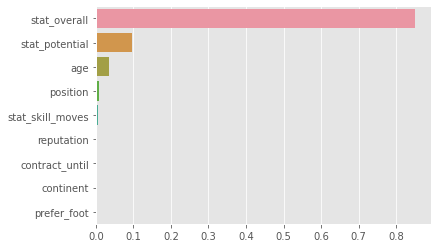

In [601]:
import seaborn as sns

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

(200, 2)


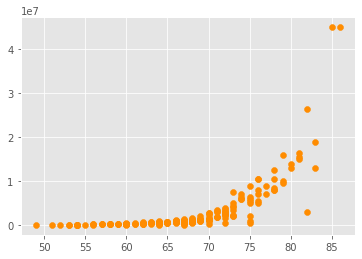

In [604]:
import matplotlib.pyplot as plt

train_df_sample = train_df[['stat_overall','value']]
train_df_sample = train_df_sample.sample(n=200,random_state=0)
print(train_df_sample.shape)
plt.figure()
plt.scatter(train_df_sample['stat_overall'] , train_df_sample['value'],c="darkorange")

plt.show()

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 셋 생성. 
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = train_df_sample['reputation'].values.reshape(-1,1)
y_target = train_df_sample['value'].values.reshape(-1,1)

# 학습과 예측 수행. 
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

NameError: name 'DecisionTreeRegressor' is not defined

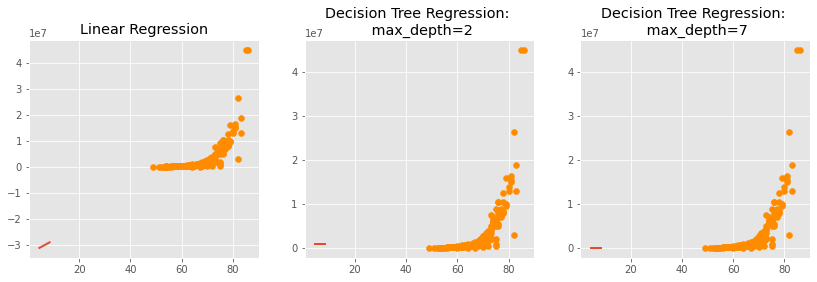

In [606]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(train_df_sample.stat_overall, train_df_sample.value, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(train_df_sample.stat_overall, train_df_sample.value, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(train_df_sample.stat_overall, train_df_sample.value, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

plt.show()

In [607]:
import xgboost as xgb
print(xgb.__version__)

1.6.1


In [608]:
from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

train_df

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,4,2021,3,0,5.0,94,94,4.0,110500000.0
1,27,2,2020,1,1,4.0,91,93,1.0,72000000.0
2,31,4,2021,3,1,5.0,91,91,3.0,80000000.0
3,32,2,2020,0,1,4.0,91,91,3.0,51000000.0
4,25,2,2021,1,1,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...
8927,18,0,2019,2,1,1.0,48,63,3.0,60000.0
8928,19,2,2020,0,1,1.0,47,59,2.0,40000.0
8929,18,4,2021,0,1,1.0,47,64,2.0,50000.0
8930,18,2,2021,1,1,1.0,47,65,1.0,50000.0


## 모델링

- 랜덤 포레스트, xgboost 사용예정,
    - train_df = train 데이터
    - test_df = test 데이터
 

In [123]:
from sklearn.ensemble import RandomForestRegressor

train_x = train_df.drop('value',axis = 1)
train_y = train_df['value']


model = RandomForestRegressor()
model.fit(train_x,train_y)

RandomForestRegressor()